02.08.2023 - Joachim Weber - https://github.com/WeberJoachim

This script shows the workflow used to analyze the transcript level quantifications from salmon.

In [ ]:
suppressMessages(library("tximport")) # 1.26.1
suppressMessages(library("DESeq2"))   # 1.38.3
suppressMessages(library("ggrepel"))  # 0.9.3
suppressMessages(library("ggplot2"))  # 3.4.2
suppressMessages(library("dplyr"))    # 1.1.2
suppressMessages(library("reshape2")) # 1.4.4


# 1. DEG - Analysis
First read the samplesheet and define the Path to the quant.sf files, produced by salmon.

In [ ]:
samples = read.csv("samplesheet.csv", row.names = 1)
rownames(samples) = samples$alias

files = file.path("results/quant", paste0(samples$alias, "_quant"), "quant.sf")
names(files) = samples$alias
all(file.exists(files))

Import and summarize the quantification data using tximport

In [ ]:
tx2gene = read.csv("AtRTD3_gene_transcript.csv")
txi     = tximport(files, type = "salmon", tx2gene = tx2gene)

Lets first plot PCA and correlation heatmap. Filter everything that has 0 abundances 

In [4]:
df              = txi$abundance

#filter 0 count rows
keep            = !apply(df,1,function(x) all(x == 0))
df              = df[keep,]

#prepare PCA
df              = t(df)
pca_object      = prcomp(df, scale=T)
summary         = summary(pca_object)
loadings        = pca_object$rotation
scores          = data.frame(pca_object$x)
legend          = gsub("_rep[1,2,3]","",row.names(scores))
scores$label    = row.names(scores)
scores$genotype = substr(scores$label, start = 1, stop = nchar(scores$label)-2)

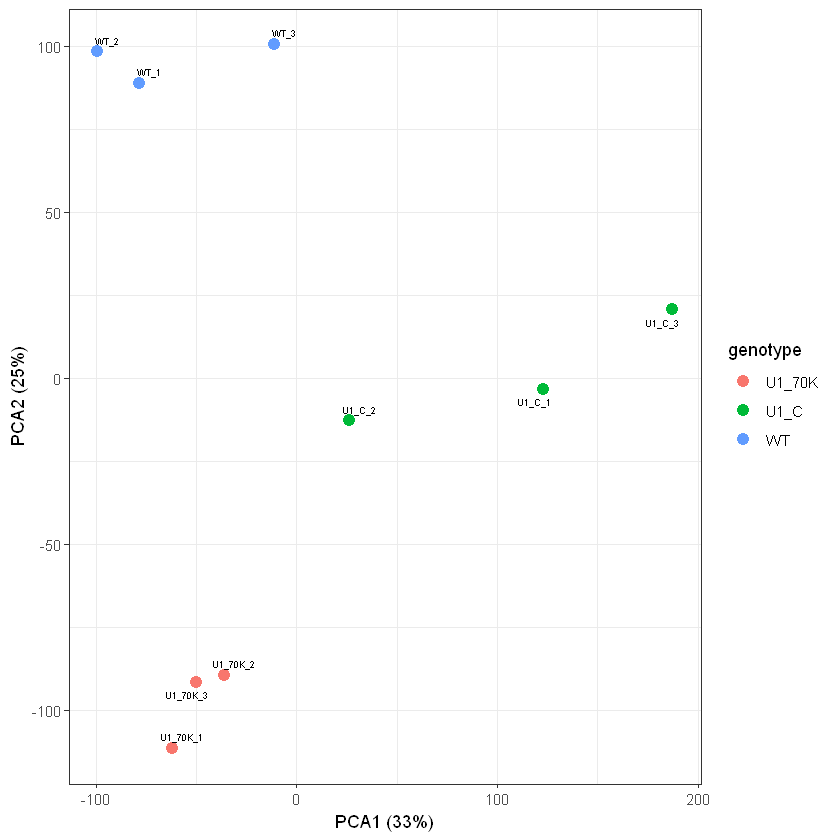

In [5]:
#PCA for PC1 and PC2

pca1 <- ggplot(data=scores,aes(x = PC1, y = PC2, color = genotype)) +
  geom_point(size=3) +
  theme_bw() +
  geom_text_repel(aes(label=label),size=2,color="black")+
  labs(x = paste0("PCA1 (",round(summary$importance[2,1]*100),"%)"),
       y = paste0("PCA2 (",round(summary$importance[2,2]*100),"%)")) 

pca1

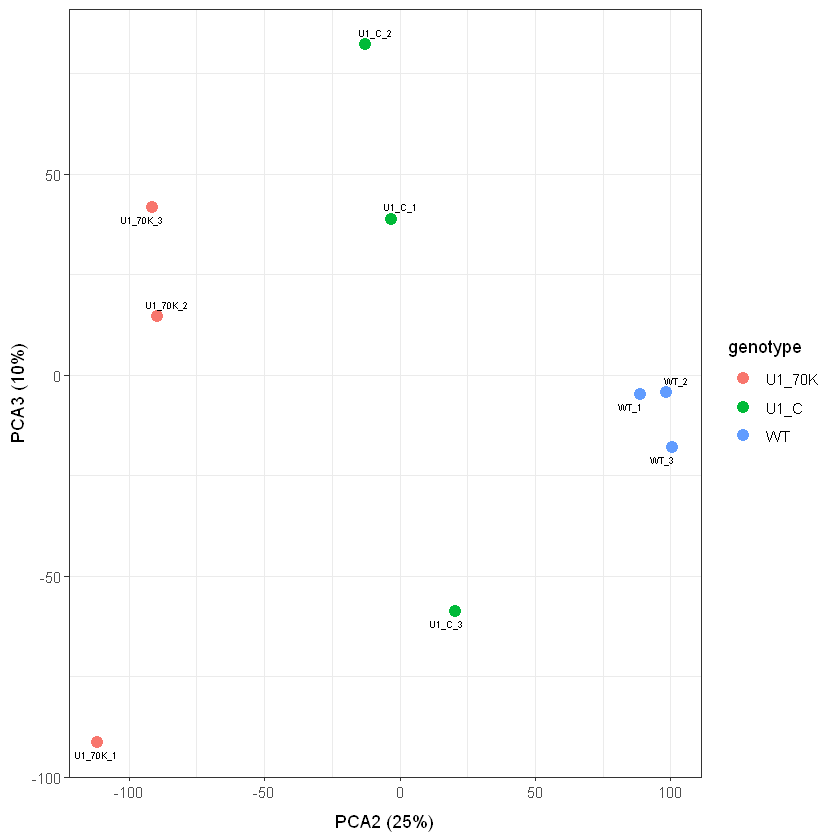

In [6]:
#PCA for PC2 and PC3

pca2 <- ggplot(data=scores,aes(x = PC2, y = PC3, color = genotype)) +
  geom_point(size=3) +
  theme_bw() +
  geom_text_repel(aes(label=label),size=2,color="black") +
  labs(x = paste0("PCA2 (",round(summary$importance[2,2]*100),"%)"),
       y = paste0("PCA3 (",round(summary$importance[2,3]*100),"%)")) 

pca2

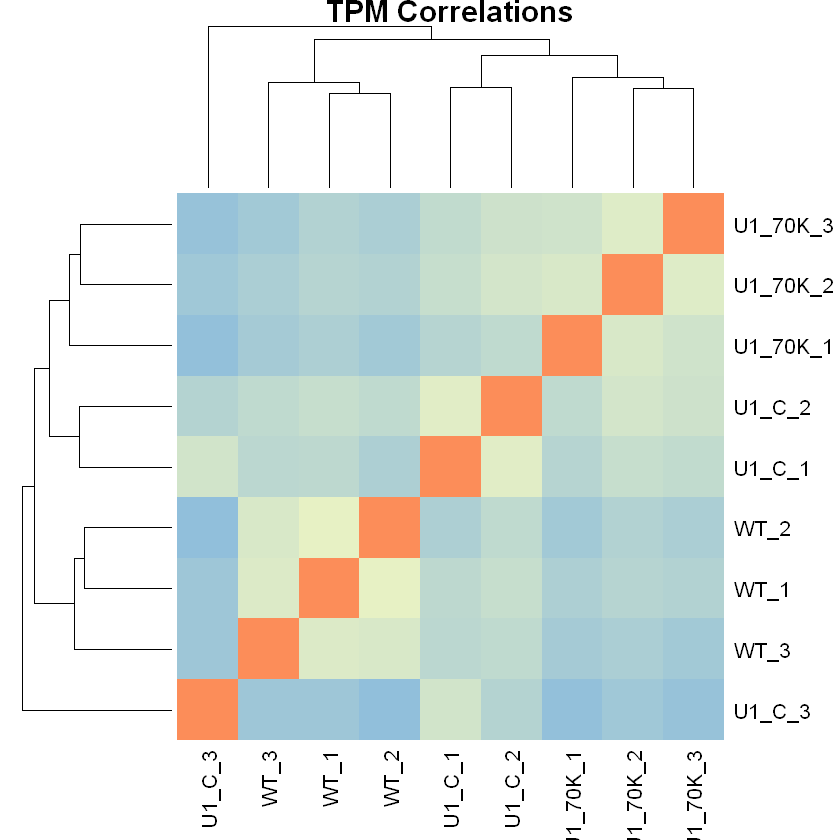

In [7]:
df              = txi$abundance
cor_matrix      = cor(df, method = "spearman")
dend            = as.dendrogram(hclust(dist(cor_matrix)))

corr_heatmap    = heatmap(cor_matrix, Rowv = dend, Colv = dend, col = colorRampPalette(c("#91BFDB", "#FFFFBF", "#FC8D59"))(100), scale = "none", main="TPM Correlations")

Based on the the correlation heatmap, we decided to leave out U1_C_rep3.
Next create the DESeq object using imported quantification, samplesheet and the list that connects transcript and gene (https://ics.hutton.ac.uk/atRTD/RTD3/AtRTD3_gene_transcript.csv)

In [ ]:
dds             = DESeqDataSetFromTximport(txi, samples, design = ~condition)
dds$condition   = factor(dds$condition, levels = c("WT","U1_C", "U1_70K"))
dds$condition   = relevel(dds$condition, ref = "WT")
dds             = dds[,-6]

Now filter all genes, that have 10 or less counts over all samples and perform deseq analysis

In [ ]:
keep    = rowSums(counts(dds)) >= 10
dds     = dds[keep,]
dds     = DESeq(dds)

Check the Dispersion Estimate to judge the quality

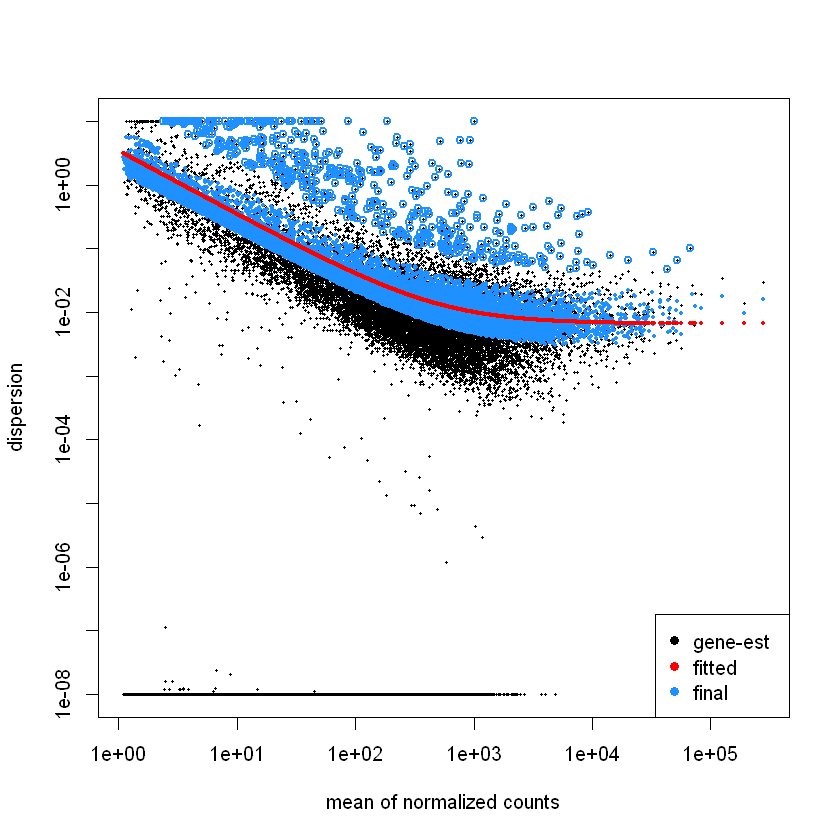

In [10]:
plotDispEsts(dds)

Extract results, check for overlaps and write the lists to csv

In [11]:
res_u1c         = results(dds, name = "condition_U1_C_vs_WT")
res_u170k       = results(dds, name = "condition_U1_70K_vs_WT")

#first single genotypes

up_u1c          = res_u1c   %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange > 0)
up_u170k        = res_u170k %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange > 0)
overlap_up      = intersect(rownames(up_u1c), rownames(up_u170k))

down_u1c        = res_u1c   %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange < 0)
down_u170k      = res_u170k %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange < 0)
overlap_down    = intersect(rownames(down_u1c), rownames(down_u170k))

write.csv(as.data.frame(res_u170k), file = "results_u170k_vs_wt.csv")
write.csv(as.data.frame(res_u1c),   file = "results_u1c_vs_wt.csv")


#now overlap

merged_up       = up_u1c %>% select(baseMean)
merged_up       = transform(merge(merged_up, up_u170k[,-1], by = 0), row.names = Row.names, Row.names=NULL)
merged_up       = transform(merge(merged_up, up_u1c[,-1],   by = 0, suffixes = c("_amiR-u1-70k", "_amirR-u1-c")), row.names = Row.names, Row.names=NULL)

merged_down     = down_u1c %>% select(baseMean)
merged_down     = transform(merge(merged_down, down_u170k[,-1], by = 0), row.names = Row.names, Row.names=NULL)
merged_down     = transform(merge(merged_down, down_u1c[,-1],   by = 0, suffixes = c("_amiR-u1-70k", "_amirR-u1-c")), row.names = Row.names, Row.names=NULL)


write.csv(merged_up,    file = "overlap_upregulated_u170k_u1c.csv")
write.csv(merged_down,  file = "overlap_downregulated_u170k_u1c.csv")

# 2. The rmats/splicing analysis

load all files

In [12]:
#first read in all tables
u1c_se      = read.table("results/rmats/U1C/WT_vs_U1C/SE.MATS.JC.txt",          header = T)
u1c_ri      = read.table("results/rmats/U1C/WT_vs_U1C/RI.MATS.JC.txt",          header = T)
u1c_a5s     = read.table("results/rmats/U1C/WT_vs_U1C/A5SS.MATS.JC.txt",        header = T)
u1c_a3s     = read.table("results/rmats/U1C/WT_vs_U1C/A3SS.MATS.JC.txt",        header = T)
u1c_mxe     = read.table("results/rmats/U1C/WT_vs_U1C/MXE.MATS.JC.txt",         header = T)



u170k_se    = read.table("results/rmats/U170K/WT_vs_U170K/SE.MATS.JC.txt",      header = T)
u170k_ri    = read.table("results/rmats/U170K/WT_vs_U170K/RI.MATS.JC.txt",      header = T)
u170k_a5s   = read.table("results/rmats/U170K/WT_vs_U170K/A5SS.MATS.JC.txt",    header = T)
u170k_a3s   = read.table("results/rmats/U170K/WT_vs_U170K/A3SS.MATS.JC.txt",    header = T)
u170k_mxe   = read.table("results/rmats/U170K/WT_vs_U170K/MXE.MATS.JC.txt",     header = T)

In [13]:
#define criteria to find same events and find overlaps between groups

overlap_se = merge(u1c_se %>% filter(FDR < 0.05) %>% 
      select(GeneID, exonStart_0base, exonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      u170k_se %>% filter(FDR < 0.05) %>% select(GeneID, exonStart_0base, exonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      by = c(1:7), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

overlap_ri = merge(u1c_ri %>% filter(FDR < 0.05) %>% 
      select(GeneID, riExonStart_0base , riExonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      u170k_ri %>% filter(FDR < 0.05) %>% select(GeneID, riExonStart_0base, riExonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      by = c(1:7), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

overlap_a5s = merge(u1c_a5s %>% filter(FDR < 0.05) %>% 
      select(GeneID, longExonStart_0base, longExonEnd, shortES, shortEE, flankingES, flankingEE,FDR, IncLevelDifference),
      u170k_a5s %>% filter(FDR < 0.05) %>% select(GeneID, longExonStart_0base, longExonEnd, shortES, shortEE, flankingES, flankingEE,FDR, IncLevelDifference),
      by = c(1:7), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

overlap_a3s = merge(u1c_a3s %>% filter(FDR < 0.05) %>%
      select(GeneID, longExonStart_0base, longExonEnd, shortES, shortEE, flankingES, flankingEE ,FDR, IncLevelDifference),
      u170k_a3s %>% filter(FDR < 0.05) %>% select(GeneID, longExonStart_0base, longExonEnd, shortES, shortEE, flankingES, flankingEE,FDR, IncLevelDifference),
      by = c(1:7), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

overlap_mxe = merge(u1c_mxe %>% filter(FDR < 0.05) %>%
      select(GeneID, X1stExonStart_0base, X1stExonEnd, X2ndExonStart_0base, X2ndExonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      u170k_mxe %>% filter(FDR < 0.05) %>% select(GeneID, X1stExonStart_0base, X1stExonEnd, X2ndExonStart_0base, X2ndExonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      by = c(1:9), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

In [14]:
#get just the numbers
numbers_u1c     = data.frame(event = c("A3SS", "A5SS", "MXE", "RI", "SE"), amount = c(1:5),     amount_up = c(1:5),     amount_down = c(1:5))
numbers_u170k   = data.frame(event = c("A3SS", "A5SS", "MXE", "RI", "SE"), amount = c(1:5),     amount_up = c(1:5),     amount_down = c(1:5))
numbers_overlap = data.frame(event = c("A3SS", "A5SS", "MXE", "RI", "SE"), overlap = c(1:5),    overlap_up = c(1:5),    overlap_down = c(1:5), ambi = c(1:5))

In [15]:
#filter by enhanced and repressed
numbers_u170k[1,2] = u170k_a3s  %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[1,3] = u170k_a3s  %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[1,4] = u170k_a3s  %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u170k[2,2] = u170k_a5s  %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[2,3] = u170k_a5s  %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[2,4] = u170k_a5s  %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u170k[3,2] = u170k_mxe  %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[3,3] = u170k_mxe  %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[3,4] = u170k_mxe  %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u170k[4,2] = u170k_ri   %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[4,3] = u170k_ri   %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[4,4] = u170k_ri   %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u170k[5,2] = u170k_se   %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[5,3] = u170k_se   %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[5,4] = u170k_se   %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow





numbers_u1c[1,2] = u1c_a3s      %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[1,3] = u1c_a3s      %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[1,4] = u1c_a3s      %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u1c[2,2] = u1c_a5s      %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[2,3] = u1c_a5s      %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[2,4] = u1c_a5s      %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u1c[3,2] = u1c_mxe      %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[3,3] = u1c_mxe      %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[3,4] = u1c_mxe      %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u1c[4,2] = u1c_ri       %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[4,3] = u1c_ri       %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[4,4] = u1c_ri       %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u1c[5,2] = u1c_se       %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[5,3] = u1c_se       %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[5,4] = u1c_se       %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow


In [16]:
#get overlap numbers
numbers_overlap[1,2] = overlap_a3s %>% nrow
numbers_overlap[1,3] = overlap_a3s %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` >= 0) %>% nrow
numbers_overlap[1,4] = overlap_a3s %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` <= 0 & `IncLevelDifference_amirR-u1-70k` <= 0) %>% nrow
numbers_overlap[1,5] = overlap_a3s %>% filter((`IncLevelDifference_amiR-u1-c`<= 0 & `IncLevelDifference_amirR-u1-70k`>= 0) | (`IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` <= 0)) %>% nrow

numbers_overlap[2,2] = overlap_a5s %>% nrow
numbers_overlap[2,3] = overlap_a5s %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` >= 0) %>% nrow
numbers_overlap[2,4] = overlap_a5s %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` <= 0 & `IncLevelDifference_amirR-u1-70k` <= 0) %>% nrow
numbers_overlap[2,5] = overlap_a5s %>% filter((`IncLevelDifference_amiR-u1-c`<= 0 & `IncLevelDifference_amirR-u1-70k`>= 0) | (`IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` <= 0)) %>% nrow

numbers_overlap[3,2] = overlap_mxe %>% nrow
numbers_overlap[3,3] = overlap_mxe %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` >= 0) %>% nrow
numbers_overlap[3,4] = overlap_mxe %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` <= 0 & `IncLevelDifference_amirR-u1-70k` <= 0) %>% nrow
numbers_overlap[3,5] = overlap_mxe %>% filter((`IncLevelDifference_amiR-u1-c`<= 0 & `IncLevelDifference_amirR-u1-70k`>= 0) | (`IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` <= 0)) %>% nrow

numbers_overlap[4,2] = overlap_ri %>% nrow
numbers_overlap[4,3] = overlap_ri %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` >= 0) %>% nrow
numbers_overlap[4,4] = overlap_ri %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` <= 0 & `IncLevelDifference_amirR-u1-70k` <= 0) %>% nrow
numbers_overlap[4,5] = overlap_ri %>% filter((`IncLevelDifference_amiR-u1-c`<= 0 & `IncLevelDifference_amirR-u1-70k`>= 0) | (`IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` <= 0)) %>% nrow

numbers_overlap[5,2] = overlap_se %>% nrow
numbers_overlap[5,3] = overlap_se %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` >= 0) %>% nrow
numbers_overlap[5,4] = overlap_se %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` <= 0 & `IncLevelDifference_amirR-u1-70k` <= 0) %>% nrow
numbers_overlap[5,5] = overlap_se %>% filter((`IncLevelDifference_amiR-u1-c`<= 0 & `IncLevelDifference_amirR-u1-70k`>= 0) | (`IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` <= 0)) %>% nrow


In [17]:
#write output data
write.csv(overlap_a3s,  "overlap_A3SS.csv")
write.csv(overlap_a5s,  "overlap_A5SS.csv")
write.csv(overlap_mxe,  "overlap_MXE.csv")
write.csv(overlap_ri,   "overlap_RI.csv")
write.csv(overlap_se,   "overlap_SE.csv")

summary = merge(merge(numbers_u1c, numbers_u170k, by = "event", suffixes = c("_u1c", "_u170k")), numbers_overlap, by = 1)

write.csv(summary, "summary.csv")

# 3. Analysis for revision

## 3.1 Nucleotide Frequency

In [ ]:
suppressMessages(library("seqTools"))
suppressMessages(library(patchwork))

### 3.1.1 Nucleotide Frequency around **proximal** PA-Sites that are from the composite repressed category in amiR-U170K

In [ ]:
fq_distal_pA_comp_rep_u170k = fastqq("results/fastq_for_nucfreq/proximal_pA_comp_rep_u170k.fq")
a = as.data.frame(nucFreq(fq_distal_pA_comp_rep_u170k,1)[1:4,])
rownames(a) = c("a","c","g","u")
colnames(a) = c(-50:49)
a = melt(as.matrix(a))
colnames(a) = c("nucleotide", "position", "frequency")
a$frequency = a$frequency/fq_distal_pA_comp_rep_u170k@nReads


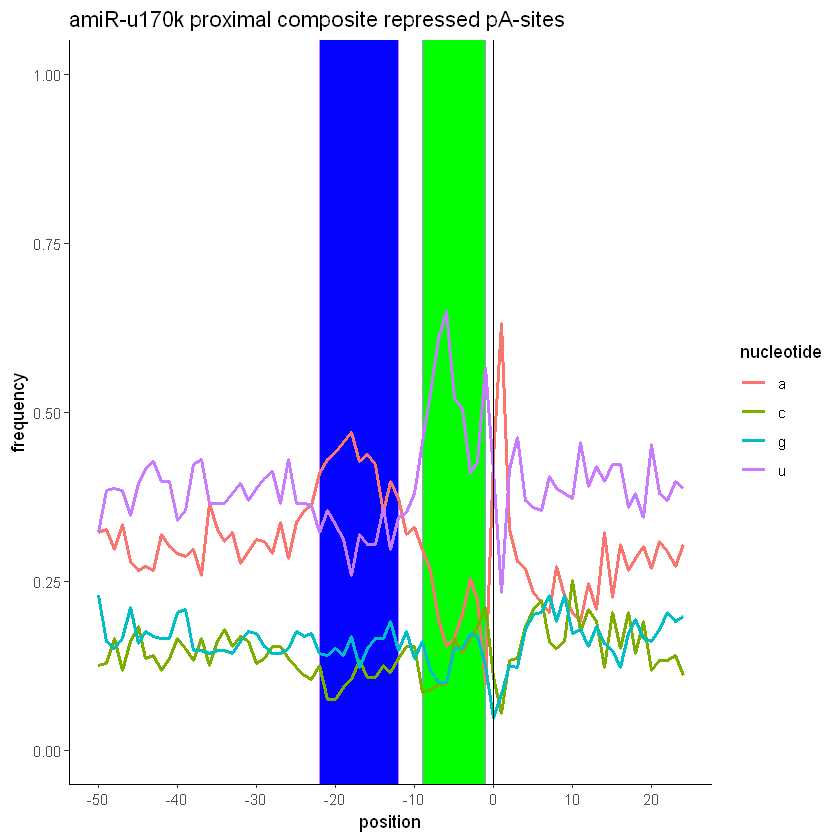

In [20]:
plot_proximal_u170k_comp_rep_pA_light = ggplot(a %>% filter(position < 25), aes(x = position, y = frequency, col = nucleotide)) +
  ggtitle("amiR-u170k proximal composite repressed pA-sites") +
  geom_rect( xmin = -22, xmax = -12, ymin = -1, ymax = 2, fill = "blue", alpha = 0.1, show.legend = FALSE) + 
  geom_rect( xmin = -9, xmax = -1, ymin = -1, ymax = 2, alpha = 0.3, fill = "green", show.legend = FALSE) + 
  geom_line(linewidth = 0.9) + 
  geom_vline(xintercept=0)  + 
  scale_x_continuous(breaks = c(-50,-40,-30,-20, -10,0,10,20,30,40,60)) +
  ylim(0,1) + 
  theme_classic()

plot_proximal_u170k_comp_rep_pA_light

### 3.1.2 Nucleotide Frequency around **distal** PA-Sites that are from the composite repressed category in amiR-U170K

In [ ]:
fq_distal_pA_where_comp_rep_u170k = fastqq("results/fastq_for_nucfreq/distal_pA_where_comp_rep_u170k.fq")
a = as.data.frame(nucFreq(fq_distal_pA_where_comp_rep_u170k,1)[1:4,])
rownames(a) = c("a","c","g","u")
colnames(a) = c(-50:49)
a = melt(as.matrix(a))
colnames(a) = c("nucleotide", "position", "frequency")

a$frequency = a$frequency/fq_distal_pA_where_comp_rep_u170k@nReads

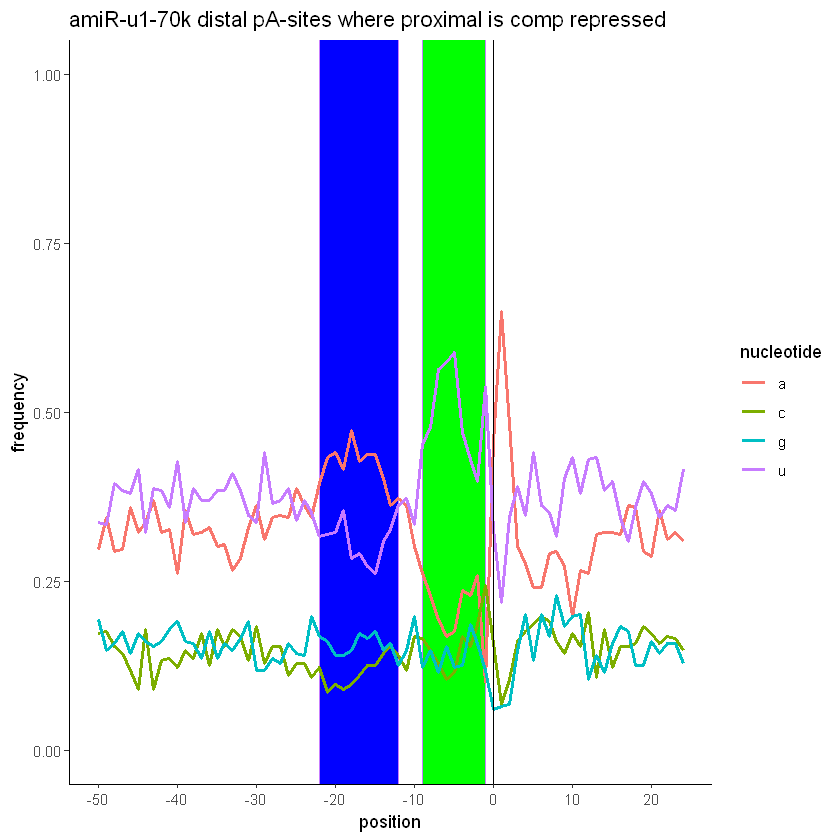

In [22]:
plot_u170k_distal_sites_light = ggplot(a %>% filter(position < 25), aes(x = position, y = frequency, col = nucleotide)) + 
  ggtitle("amiR-u1-70k distal pA-sites where proximal is comp repressed") + 
  geom_rect( xmin = -22, xmax = -12, ymin = -1, ymax = 2, fill = "blue", alpha = 0.3, show.legend = FALSE) + 
  geom_rect( xmin = -9, xmax = -1, ymin = -1, ymax = 2, alpha = 0.3, fill = "green", show.legend = FALSE) + 
  geom_line(linewidth = 0.9) + 
  geom_vline(xintercept=0)  + 
  scale_x_continuous(breaks = c(-50,-40,-30,-20, -10,0,10,20,30,40,60)) + 
  ylim(0,1) +
  theme_classic()

plot_u170k_distal_sites_light

### 3.1.3 Nucleotide Frequency around **proximal** PA-Sites that are from the composite repressed category in amiR-U1C

In [ ]:
fq_proximal_pA_comp_rep_u1c = fastqq("results/fastq_for_nucfreq/proximal_pA_comp_rep_u1c.fq")
a = as.data.frame(nucFreq(fq_proximal_pA_comp_rep_u1c,1)[1:4,])
rownames(a) = c("a","c","g","u")
colnames(a) = c(-50:49)
a = melt(as.matrix(a))
colnames(a) = c("nucleotide", "position", "frequency")
a$frequency = a$frequency/fq_proximal_pA_comp_rep_u1c@nReads

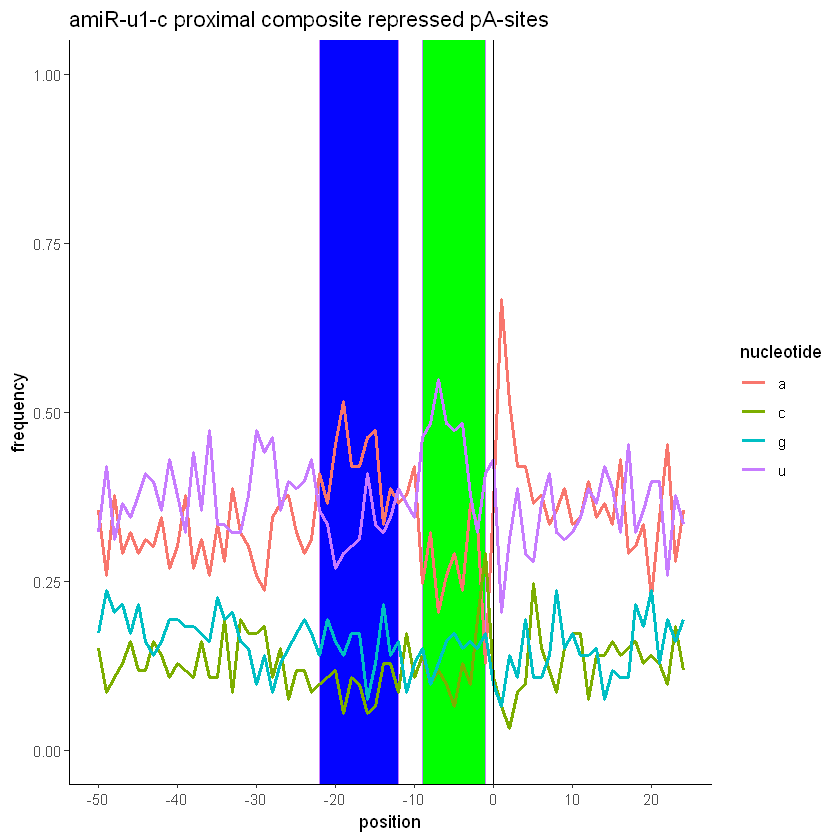

In [25]:
plot_proximal_u1c_comp_rep_pA_light = ggplot(a %>% filter(position < 25), aes(x = position, y = frequency, col = nucleotide)) +
  ggtitle("amiR-u1-c proximal composite repressed pA-sites") +
  geom_rect( xmin = -22, xmax = -12, ymin = -1, ymax = 2, fill = "blue", alpha = 0.1, show.legend = FALSE) + 
  geom_rect( xmin = -9, xmax = -1, ymin = -1, ymax = 2, alpha = 0.3, fill = "green", show.legend = FALSE) + 
  geom_line(linewidth = 0.9) + 
  geom_vline(xintercept=0)  + 
  scale_x_continuous(breaks = c(-50,-40,-30,-20, -10,0,10,20,30,40,60)) +
  ylim(0,1) + 
  theme_classic()

plot_proximal_u1c_comp_rep_pA_light


### 3.1.4 Nucleotide Frequency around **distal** PA-Sites that are from the composite repressed category in amiR-U1C

In [ ]:
fq_distal_u1c_comp_rep_pA_light = fastqq("results/fastq_for_nucfreq/distal_pA_where_comp_rep_u1c.fq")
a = as.data.frame(nucFreq(fq_distal_u1c_comp_rep_pA_light,1)[1:4,])
rownames(a) = c("a","c","g","u")
colnames(a) = c(-50:49)
a = melt(as.matrix(a))
colnames(a) = c("nucleotide", "position", "frequency")
a$frequency = a$frequency/fq_distal_u1c_comp_rep_pA_light@nReads

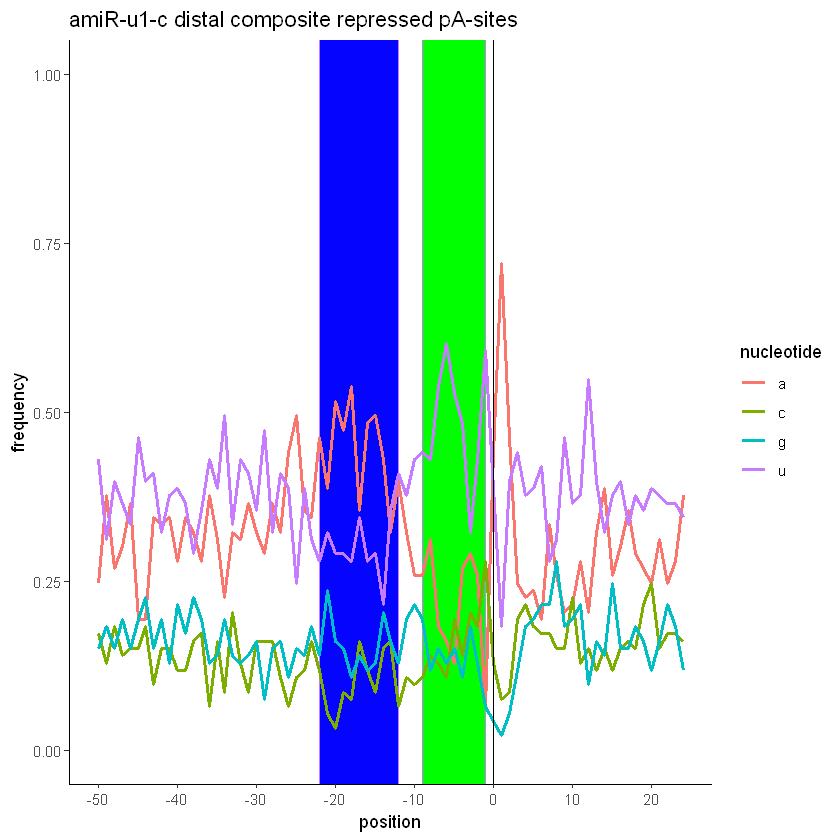

In [27]:
plot_distal_u1c_comp_rep_pA_light = ggplot(a %>% filter(position < 25), aes(x = position, y = frequency, col = nucleotide)) +
  ggtitle("amiR-u1-c distal composite repressed pA-sites") +
  geom_rect( xmin = -22, xmax = -12, ymin = -1, ymax = 2, fill = "blue", alpha = 0.1, show.legend = FALSE) + 
  geom_rect( xmin = -9, xmax = -1, ymin = -1, ymax = 2, alpha = 0.3, fill = "green", show.legend = FALSE) + 
  geom_line(linewidth = 0.9) + 
  geom_vline(xintercept=0)  + 
  scale_x_continuous(breaks = c(-50,-40,-30,-20, -10,0,10,20,30,40,60)) +
  ylim(0,1) + 
  theme_classic()

plot_distal_u1c_comp_rep_pA_light

### 3.1.5 Nucleotide Frequency around the PA-sites that are normally used by the WT and are unaffected by the knockdown of U1C or U170K


In [ ]:
fq_non_affected_WT_PAs = fastqq("results/fastq_for_nucfreq/non_affected_WT_consensus_pA_sites.fq")
a = as.data.frame(nucFreq(fq_non_affected_WT_PAs,1)[1:4,])
rownames(a) = c("a","c","g","u")
colnames(a) = c(-50:49)
a = melt(as.matrix(a))
colnames(a) = c("nucleotide", "position", "frequency")
a$frequency = a$frequency/fq_non_affected_WT_PAs@nReads

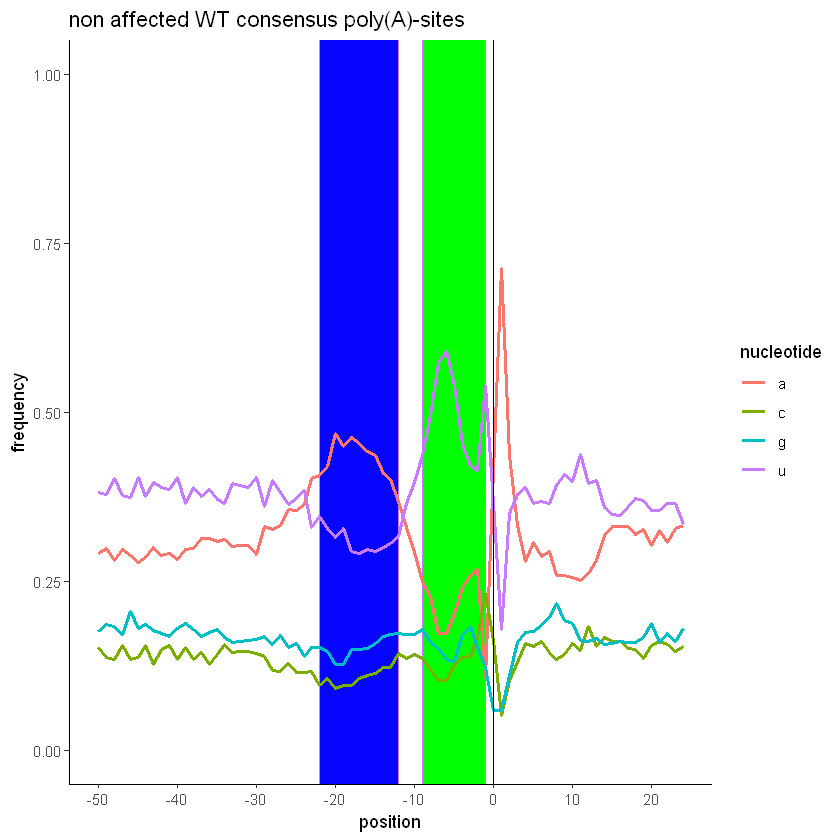

In [29]:
plot_non_affected_WT_PAs_light = ggplot(a %>% filter(position < 25), aes(x = position, y = frequency, col = nucleotide)) +
  ggtitle("non affected WT consensus poly(A)-sites") +
  geom_rect( xmin = -22, xmax = -12, ymin = -1, ymax = 2, fill = "blue", alpha = 0.1, show.legend = FALSE) + 
  geom_rect( xmin = -9, xmax = -1, ymin = -1, ymax = 2, alpha = 0.3, fill = "green", show.legend = FALSE) + 
  geom_line(linewidth = 0.9) + 
  geom_vline(xintercept=0)  + 
  scale_x_continuous(breaks = c(-50,-40,-30,-20, -10,0,10,20,30,40,60)) +
  ylim(0,1) + 
  theme_classic()

plot_non_affected_WT_PAs_light

### 3.1.6 Nucleotide Frequency around the position that is at 1/3 of the intron length of all introns

In [ ]:
fq_onethird_of_all_introns = fastqq("results/fastq_for_nucfreq/bed_position_at_onethird_of_all_introns.fq")
a = as.data.frame(nucFreq(fq_onethird_of_all_introns,1)[1:4,])
rownames(a) = c("a","c","g","u")
colnames(a) = c(-50:49)
a = melt(as.matrix(a))
colnames(a) = c("nucleotide", "position", "frequency")
a$frequency = a$frequency/fq_onethird_of_all_introns@nReads

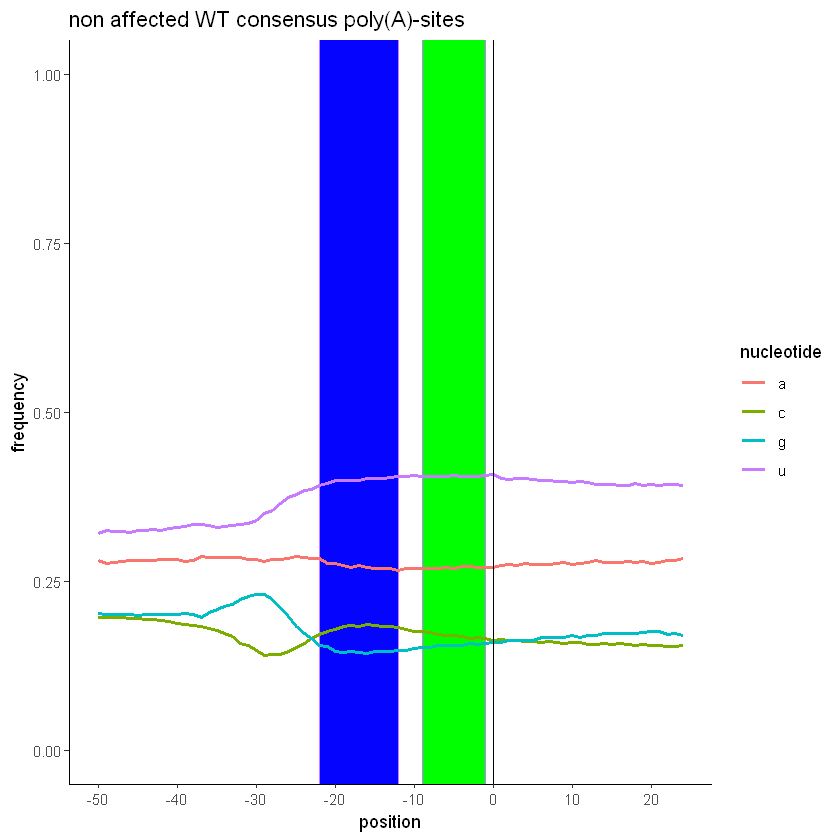

In [31]:
plot_onethird_of_all_introns_light = ggplot(a %>% filter(position < 25), aes(x = position, y = frequency, col = nucleotide)) +
  ggtitle("non affected WT consensus poly(A)-sites") +
  geom_rect( xmin = -22, xmax = -12, ymin = -1, ymax = 2, fill = "blue", alpha = 0.1, show.legend = FALSE) + 
  geom_rect( xmin = -9, xmax = -1, ymin = -1, ymax = 2, alpha = 0.3, fill = "green", show.legend = FALSE) + 
  geom_line(linewidth = 0.9) + 
  geom_vline(xintercept=0)  + 
  scale_x_continuous(breaks = c(-50,-40,-30,-20, -10,0,10,20,30,40,60)) +
  ylim(0,1) + 
  theme_classic()

plot_onethird_of_all_introns_light

## 3.2 Overlaps between DEGs and splicing events

In [77]:
significant_degs_overlap = merge(as.data.frame(res_u1c), as.data.frame(res_u170k), by = 0, suffixes = c("_u1c", "_u170k"))
colnames(significant_degs_overlap)[1] = "GeneID"

significant_degs_overlap = significant_degs_overlap %>% filter(padj_u1c < 0.05 & padj_u170k < 0.05)


overlap_deg_rmats_se  = merge(significant_degs_overlap, overlap_se, by = "GeneID", suffixes = c("_deg", "_rmats")) 
overlap_deg_rmats_ri  = merge(significant_degs_overlap, overlap_ri, by = "GeneID", suffixes = c("_deg", "_rmats"))
overlap_deg_rmats_a5s = merge(significant_degs_overlap, overlap_a5s, by = "GeneID", suffixes = c("_deg", "_rmats")) 
overlap_deg_rmats_a3s = merge(significant_degs_overlap, overlap_a3s, by = "GeneID", suffixes = c("_deg", "_rmats"))
overlap_deg_rmats_mxe = merge(significant_degs_overlap, overlap_mxe, by = "GeneID", suffixes = c("_deg", "_rmats")) 


universe_se  = length(unique(c(significant_degs_overlap$GeneID, overlap_se$GeneID)))
universe_ri  = length(unique(c(significant_degs_overlap$GeneID, overlap_ri$GeneID)))
universe_a5s = length(unique(c(significant_degs_overlap$GeneID, overlap_a5s$GeneID)))
universe_a3s = length(unique(c(significant_degs_overlap$GeneID, overlap_a3s$GeneID)))
universe_mxe = length(unique(c(significant_degs_overlap$GeneID, overlap_mxe$GeneID)))



a = phyper(nrow(overlap_deg_rmats_se)-1,  2374, universe_se-2374,  nrow(overlap_se),  lower.tail = F) 
b = phyper(nrow(overlap_deg_rmats_ri)-1,  2374, universe_ri-2374,  nrow(overlap_ri),  lower.tail = F) 
c = phyper(nrow(overlap_deg_rmats_a5s)-1, 2374, universe_a5s-2374, nrow(overlap_a5s), lower.tail = F) 
d = phyper(nrow(overlap_deg_rmats_a3s)-1, 2374, universe_a3s-2374, nrow(overlap_a3s), lower.tail = F) 
e = phyper(nrow(overlap_deg_rmats_mxe)-1, 2374, universe_mxe-2374, nrow(overlap_mxe), lower.tail = F) 



print(paste0("p-Value of hypergeometic test for significance of overlap between DEGs and skipped exon events = ", a))
print(paste0("p-Value of hypergeometic test for significance of overlap between DEGs and retained intron events = ", b))
print(paste0("p-Value of hypergeometic test for significance of overlap between DEGs and alternative 5'SS events = ", c))
print(paste0("p-Value of hypergeometic test for significance of overlap between DEGs and alternative 3'SS events = ", d))
print(paste0("p-Value of hypergeometic test for significance of overlap between DEGs and mutually exclusive exon events = ", e))


#now test all Rmats events vs all degs
universe_diff_spliced_deg = length(unique(c(significant_degs_overlap$GeneID, overlap_a3s$GeneID, overlap_a5s$GeneID, overlap_ri$GeneID, overlap_se$GeneID, overlap_mxe$GeneID)))
universe_diff_spliced =  length(unique(c(overlap_a3s$GeneID, overlap_a5s$GeneID, overlap_ri$GeneID, overlap_se$GeneID, overlap_mxe$GeneID)))
overlap_deg_diffpliced = length(intersect(significant_degs_overlap$GeneID, unique(c(overlap_a3s$GeneID, overlap_a5s$GeneID, overlap_ri$GeneID, overlap_se$GeneID, overlap_mxe$GeneID))))


f = phyper(overlap_deg_diffpliced-1, 2374, universe_diff_spliced_deg - 2374, universe_diff_spliced, lower.tail = F)
results_overlap_degs_all_rmats = paste0("The probability that the overlap (312) between all differently expressed genes (2374) and all genes with at least one splicing event (1754), where all possible genes are 3816 is happening by chance is ",f )
print(results_overlap_degs_all_rmats)




[1] "p-Value of hypergeometic test for significance of overlap between DEGs and skipped exon events = 1"
[1] "p-Value of hypergeometic test for significance of overlap between DEGs and retained intron events = 1"
[1] "p-Value of hypergeometic test for significance of overlap between DEGs and alternative 5'SS events = 1"
[1] "p-Value of hypergeometic test for significance of overlap between DEGs and alternative 3'SS events = 1"
[1] "p-Value of hypergeometic test for significance of overlap between DEGs and mutually exclusive exon events = 1"
[1] "The probability that the overlap (312) between all differently expressed genes (2374) and all genes with at least one splicing event (1754), where all possible genes are 3816 is happening by chance is 1"


## 3.3 Overlap DEGs and genes encoding mRNA cleavage and polyadenylation factors

In [81]:
pafactors = read.csv("../polyAfactoren.csv", header = F)

In [88]:
rownames(pafactors) = pafactors$V2

a = merge(pafactors, as.data.frame(res_u1c), by = 0, suffixes = c("", "_u1c"))
rownames(a) = a$Row.names
a$Row.names = NULL

a = merge(a, as.data.frame(res_u170k), by = 0, suffixes = c("", "_u170k"))
a$Row.names = NULL

a = a %>% filter(padj < 0.05 & padj_u170k < 0.05)

colnames(a)[1] = "alias"
colnames(a)[2] = "gene"

write.csv(a, "significant_DE_polyA_factors_u1_project.csv", quote = F, row.names = T)


## 3.5 Overlap between alternative splicing events and genes encoding mRNA cleavage and polyadenylation factors

In [87]:
a = merge(pafactors %>% select(V2, V1), as.data.frame(overlap_a3s %>% select(GeneID, `FDR_amiR-u1-c`, `FDR_amirR-u1-70k`)), by = 1, all.x = TRUE)
a = merge(a, as.data.frame(overlap_a5s %>% select(GeneID, `FDR_amiR-u1-c`, `FDR_amirR-u1-70k`)), by = 1, all.x = TRUE, suffixes = c("_A3SS","_A5SS"))
a = merge(a, as.data.frame(overlap_mxe %>% select(GeneID, `FDR_amiR-u1-c`, `FDR_amirR-u1-70k`)), by = 1, all.x = TRUE)
a = merge(a, as.data.frame(overlap_ri %>% select(GeneID, `FDR_amiR-u1-c`, `FDR_amirR-u1-70k`)), by = 1, suffixes = c("_MXE","_RI"), all.x = TRUE )
a = merge(a, as.data.frame(overlap_se %>% select(GeneID, `FDR_amiR-u1-c`, `FDR_amirR-u1-70k`)), by = 1, all.x = TRUE )

write.csv(a, file = "pa_factors_rmats_overlap.csv")

## 3.6 Find CPA-Signal in Introns

for this we need to run the extract_motifinfo.sh after the nextflow pipeline, to then use the data in R

In [89]:
sessionInfo()

R version 4.2.2 (2022-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22631)

Matrix products: default

locale:
[1] LC_COLLATE=English_Germany.utf8  LC_CTYPE=English_Germany.utf8   
[3] LC_MONETARY=English_Germany.utf8 LC_NUMERIC=C                    
[5] LC_TIME=English_Germany.utf8    

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.2.0             seqTools_1.32.0            
 [3] zlibbioc_1.44.0             reshape2_1.4.4             
 [5] dplyr_1.1.4                 ggrepel_0.9.5              
 [7] ggplot2_3.5.0               DESeq2_1.38.3              
 [9] SummarizedExperiment_1.28.0 Biobase_2.58.0             
[11] MatrixGenerics_1.10.0       matrixStats_1.2.0          
[13] GenomicRanges_1.50.2        GenomeInfoDb_1.34.9        
[15] IRanges_2.32.0              S4Vectors_0.36.2           
[17] BiocGenerics_0.44.0         tximport